In [ ]:
import scipy.io
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import numpy as np

# Предобработка данных

In [ ]:
from google.colab import files

# Загрузка файлов
uploaded = files.upload()

Saving dm.mat to dm.mat
Saving flows.mat to flows.mat


In [ ]:
# Загрузка данных из файлов .mat
dm_data = scipy.io.loadmat('dm.mat')
flows_data = scipy.io.loadmat('flows.mat')

In [ ]:
# Просмотр содержимого .mat файла
print(dm_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'dm'])


In [ ]:
# Просмотр содержимого .mat файла
print(flows_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'flows'])


In [ ]:
# Предположим, что данные хранятся в переменных 'dm' и 'flows'
dm = dm_data['dm']
flows = flows_data['flows']

In [ ]:
# Преобразуем данные в 2D массивы, если они трехмерные
# Например, если dm имеет форму (n_samples, n_features, n_time_steps),
# то можно преобразовать его в (n_samples, n_features * n_time_steps)
dm_reshaped = dm.reshape(dm.shape[-1], -1)
flows_reshaped = flows.reshape(flows.shape[-1], -1)

In [ ]:
print(f"Размер X: {dm_reshaped.shape}")
print(f"Размер y: {flows_reshaped.shape}")

Размер X: (10000, 576)
Размер y: (10000, 576)


In [ ]:
# Преобразование массива в DataFrame
df = pd.DataFrame(dm_reshaped)

# Сохранение DataFrame в .csv файл
df.to_csv('dm_new.csv', index=True)

In [ ]:
# Преобразование массива в DataFrame
df_flows = pd.DataFrame(flows_reshaped)

# Сохранение DataFrame в .csv файл
df_flows.to_csv('flows_new.csv', index=False)

In [ ]:
input_data = pd.read_csv('dm_new.csv')
output_data = pd.read_csv('flows_new.csv')

In [ ]:
# Преобразование в numpy массивы
X = input_data.values  # Размер (10000, 576)
y = output_data.values  # Размер (10000, 576)

In [ ]:
# Нормализация входных данных
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Нормализация выходных данных
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# Linear Regression

In [ ]:
# Удаление первого столбца (индексы)
X_scaled = X_scaled[:, 1:]  # Все строки, начиная со второго столбца

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

print("Форма X_train:", X_train.shape)
print("Форма X_test:", X_test.shape)
print("Форма y_train:", y_train.shape)
print("Форма y_test:", y_test.shape)

Форма X_train: (8000, 576)
Форма X_test: (2000, 576)
Форма y_train: (8000, 576)
Форма y_test: (2000, 576)


In [ ]:
# Функция для вычисления R²:
def r2_score_linear(y_true, y_pred):
    y_mean = np.mean(y_true, axis=0)
    numerator = np.sum(np.abs(y_true - y_pred), axis=0)
    denominator = np.sum(np.abs(y_true - y_mean), axis=0)
    denominator = np.where(denominator == 0, 1e-10, denominator)
    r2 = 1 - (numerator / denominator)
    return np.mean(r2)

In [ ]:
# Создание модели линейной регрессии
model = LinearRegression()

# Обучение модели
model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred_scaled = model.predict(X_test)

# Обратное преобразование для y_pred и y_test
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test)

In [ ]:
# Вычисление R²:
r2 = r2_score_linear(y_test_original, y_pred)
print("R² на тестовой выборке:", r2)

R² на тестовой выборке: 0.015150093055825395


# KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Создание модели k-NN
knn_model = KNeighborsRegressor(n_neighbors=5)  # Используем 5 соседей

# Обучение модели
knn_model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred_scaled = knn_model.predict(X_test)

# Обратное преобразование для y_pred и y_test
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test)

In [ ]:
# Вычисление R²:
r2 = r2_score_linear(y_test_original, y_pred)
print("R² на тестовой выборке:", r2)

R² на тестовой выборке: 0.036211702483291974


# Evaluate Multioutput Regression with Cross-Validation for KNN

In [ ]:
# Функция для вычисления R²:
def r2_score_knn_cv(y_true, y_pred):
    y_mean = np.mean(y_true, axis=0)
    numerator = np.sum(np.abs(y_true - y_pred), axis=0)
    denominator = np.sum(np.abs(y_true - y_mean), axis=0)
    denominator = np.where(denominator == 0, 1e-10, denominator)
    r2 = abs(1 - (numerator / denominator))
    return np.mean(r2)

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer

# Создание пользовательской метрики
r2_scorer = make_scorer(r2_score_knn_cv, greater_is_better=True)

# Создание модели KNN
knn_model_for_cv = KNeighborsRegressor(n_neighbors=5)  # Используем 5 соседей

# Кросс-валидация с вычислением R²
cv_scores = cross_val_score(knn_model_for_cv, X_scaled, y_scaled, cv=10, scoring=r2_scorer)

# Вывод результатов кросс-валидации
print("R² на каждом фолде:", cv_scores)
print("Средний R²:", np.mean(cv_scores))

R² на каждом фолде: [0.100115   0.08638881 0.34541945 0.11274015 0.03733794 0.21261832
 0.03003709 0.1055992  0.20538216 0.06264736]
Средний R²: 0.12982854678429462


In [ ]:
# Обучение модели на всех данных
knn_model_for_cv.fit(X_scaled, y_scaled)

# Предсказание на всех данных (для визуализации)
y_pred_scaled = knn_model_for_cv.predict(X_scaled)

# Обратное преобразование для y_pred и y_scaled
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_original = scaler_y.inverse_transform(y_scaled)

In [ ]:
# Вычисление R²:
r2 = r2_score_knn_cv(y_original, y_pred)
print("R² на тестовой выборке:", r2)

R² на тестовой выборке: 0.17341358353724015


# Нейросеть (Полносвязная)

In [ ]:
import tensorflow as tf
import keras
from keras import layers

In [ ]:
# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

print("Размер обучающей выборки (X_train):", X_train.shape)
print("Размер тестовой выборки (X_test):", X_test.shape)

Размер обучающей выборки (X_train): (8000, 576)
Размер тестовой выборки (X_test): (2000, 576)


In [ ]:
print("Новая форма X_train:", X_train.shape)
print("Новая форма X_test:", X_test.shape)

Новая форма X_train: (8000, 576)
Новая форма X_test: (2000, 576)


In [ ]:
# Параметры модели
input_dim = X_train.shape[1]  # 576
hidden_dim1 = 512  # Количество нейронов в первом скрытом слое
hidden_dim2 = 256  # Количество нейронов во втором скрытом слое
output_dim = y_train.shape[1]  # 576

# Инициализация весов и biases
W1 = tf.Variable(tf.random.normal([input_dim, hidden_dim1], stddev=0.1))
b1 = tf.Variable(tf.zeros([hidden_dim1]))

W2 = tf.Variable(tf.random.normal([hidden_dim1, hidden_dim2], stddev=0.1))
b2 = tf.Variable(tf.zeros([hidden_dim2]))

W3 = tf.Variable(tf.random.normal([hidden_dim2, output_dim], stddev=0.1))
b3 = tf.Variable(tf.zeros([output_dim]))



In [ ]:
# Приведение данных к float32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Инициализация весов и biases с типом float32
W1 = tf.Variable(tf.random.normal([input_dim, hidden_dim1], stddev=0.1
                                  , dtype=tf.float32
                                  ))
b1 = tf.Variable(tf.zeros([hidden_dim1]
                          ,dtype=tf.float32
                          ))

W2 = tf.Variable(tf.random.normal([hidden_dim1, hidden_dim2], stddev=0.1, dtype=tf.float32))
b2 = tf.Variable(tf.zeros([hidden_dim2]
                          , dtype=tf.float32
                          ))

W3 = tf.Variable(tf.random.normal([hidden_dim2, output_dim], stddev=0.1
                                  , dtype=tf.float32
                                  ))
b3 = tf.Variable(tf.zeros([output_dim]
                          , dtype=tf.float32
                          ))

# Функция для forward pass (прямого прохода)
def forward_pass(X_scaled):
    hidden1 = tf.nn.relu(tf.matmul(X_scaled, W1) + b1)
    hidden2 = tf.nn.relu(tf.matmul(hidden1, W2) + b2)
    output = tf.matmul(hidden2, W3) + b3
    return output

# Функция потерь (MSE)
def compute_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))




In [ ]:
# Функция для вычисления R²
def r2_score_nn(y_true, y_pred):
    y_mean = np.mean(y_true, axis=0)
    numerator = np.sum(np.abs(y_true - y_pred), axis=0)
    denominator = np.sum(np.abs(y_true - y_mean), axis=0)
    denominator = np.where(denominator == 0, 1e-10, denominator)
    r2 = 1 - (numerator / denominator)
    return np.mean(r2)

In [ ]:
# Параметры обучения
learning_rate = 0.001
epochs = 5
batch_size = 32

# Оптимизатор
optimizer = tf.optimizers.Adam(learning_rate)

# Списки для сохранения значений R²
train_r2_history = []
val_r2_history = []

# Обучение модели
for epoch in range(epochs):
    print(f"Эпоха {epoch + 1}/{epochs}")
    for i in range(0, len(X_train), batch_size):
        # Получаем батч данных
        X_batch = X_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]

        # Вычисляем градиенты и обновляем веса
        with tf.GradientTape() as tape:
            y_pred = forward_pass(X_batch)
            loss = compute_loss(y_batch, y_pred)
        gradients = tape.gradient(loss, [W1, b1, W2, b2, W3, b3])
        optimizer.apply_gradients(zip(gradients, [W1, b1, W2, b2, W3, b3]))

    # Вычисление R² на обучающей и тестовой выборках
    y_train_pred_scaled = forward_pass(X_train)
    y_test_pred_scaled = forward_pass(X_test)

    # Обратное преобразование для y_pred
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.numpy())
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.numpy())

    # Обратное преобразование для y_true
    y_train_original = scaler_y.inverse_transform(y_train)
    y_test_original = scaler_y.inverse_transform(y_test)

    # Вычисление R²
    train_r2 = r2_score_nn(y_train_original, y_train_pred)
    val_r2 = r2_score_nn(y_test_original, y_test_pred)

    # Сохранение значений R²
    val_r2_history.append(val_r2)

    print(f"1- R² (валидация): {val_r2:.4f}")

Эпоха 1/5
1- R² (валидация): 0.0911
Эпоха 2/5
1- R² (валидация): 0.0719
Эпоха 3/5
1- R² (валидация): 0.0878
Эпоха 4/5
1- R² (валидация): 0.0956
Эпоха 5/5
1- R² (валидация): 0.0934


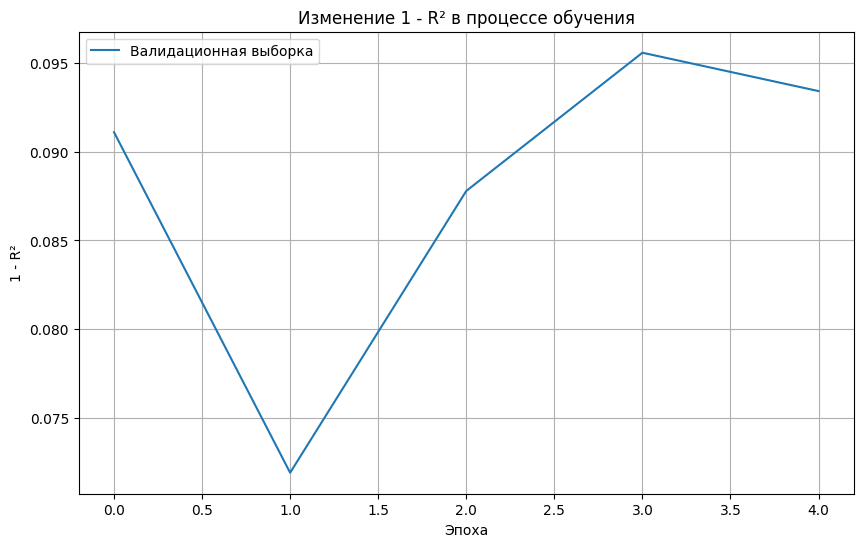

In [ ]:
# График 1 - R²
plt.figure(figsize=(10, 6))
plt.plot(val_r2_history, label='Валидационная выборка')
plt.title('Изменение 1 - R² в процессе обучения')
plt.xlabel('Эпоха')
plt.ylabel('1 - R²')
plt.legend()
plt.grid(True)
plt.show()

# Нейросеть (Сверточная)

In [ ]:
# Для CNN
import tensorflow as tf
import keras
from keras import Sequential
from keras import layers
from keras import models

In [ ]:
# Преобразование данных в numpy массивы
X = input_data.values  # Размерность: 10000 x 576
y = output_data.values  # Размерность: 10000 x 576

In [ ]:
# Удаление первого столбца (индексы)
X = X[:, 1:]  # Все строки, начиная со второго столбца

In [ ]:
# Нормализация входных данных
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Нормализация выходных данных
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

In [ ]:
# Проверка формы данных
print(f"Форма X: {X_scaled.shape}")  # Должно быть (10000, 576)
print(f"Форма y: {y_scaled.shape}")  # Должно быть (10000, 576)

Форма X: (10000, 576)
Форма y: (10000, 576)


In [ ]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [ ]:
# Создание модели
input_layer = tf.keras.layers.Input(shape=(576,))
x = tf.keras.layers.Dense(1024, activation='relu')(input_layer)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output_layer = tf.keras.layers.Dense(576)(x)  # Выходной слой с 576 нейронами (по одному на каждый признак)

model_cnn = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
model_cnn.compile(optimizer='adam', loss='mse')




In [ ]:
# Функция для расчета R² на каждой эпохе
class R2Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(X_test)
        r2 = r2_score_nn(y_test, y_pred)  # Средний R² по всем выходам
        print(f"Epoch {epoch+1}: R² = {r2:.4f}")

In [ ]:
# Обучение модели
history = model_cnn.fit(X_train, y_train, epochs=5, batch_size=32,
                    validation_split=0.2, callbacks=[R2Callback()])


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1: R² = 0.1495
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 0.2461 - val_loss: 1.0180
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 2: R² = 0.1236
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.2569 - val_loss: 1.0144
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 3: R² = 0.1704
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.2858 - val_loss: 1.0081
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Epoch 4: R² = 0.1456
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.2373 - val_loss: 0.9995
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 5: R² = 0.1933
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.2114 - val_loss: 0.9971
